If you can't quite align two FITS because of incorrect WCS,   
assume one WCS is correct (reference),   
then fix the WCS of one of the other image (input)   
based on catalogs of objects detected in the images.

Works with JWST Level 3 Pipeline products (images and catalogs).  
Here I correct the WCS of a NIRCam long wavelength image F277W  
and register it to a NIRCam short wavelength image F200W.

This is a quick and dirty solution for a small 0.03" pixel offset that should be corrected soon.  

This code should also be useful for other images, including HST, MIRI...

Using tweakwcs:  
https://github.com/spacetelescope/tweakwcs/blob/master/notebooks/align_fits_wcs.ipynb

In [1]:
import tweakwcs
from tweakwcs import fit_wcs, align_wcs, FITSWCS, TPMatch, WCSImageCatalog
from stwcs.wcsutil import HSTWCS
from drizzlepac import updatehdr
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import os



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [5]:
# Reference image
reference_image_dir = '../images'
reference_image = 'jw02736-o001_t001_nircam_clear-f200w_i2d.fits'
reference_image = os.path.join(reference_image_dir, reference_image)
reference_hdu_list = fits.open(reference_image)
reference_idata = 1
reference_header = reference_hdu_list[reference_idata].header
reference_wcs = HSTWCS(reference_hdu_list, reference_idata)
reference_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.7557344895707  -73.4677295764111  
CRPIX : 5098.704758950612  2375.034256420994  
PC1_1 PC1_2  : 0.8135808734804351  0.5814517712646615  
PC2_1 PC2_2  : 0.5814517712646615  -0.8135808734804351  
CDELT : 8.6745871630628e-06  8.6745871630628e-06  
NAXIS : 10276  4766

In [48]:
# Reference catalog
reference_catalog_dir = '../images'
reference_catalog_file = 'jw02736-o001_t001_nircam_clear-f200w_cat.ecsv'
reference_catalog_file = os.path.join(reference_catalog_dir, reference_catalog_file)
reference_catalog = ascii.read(reference_catalog_file)
reference_catalog[:2]  # see the first few rows -OR- .columns to list the column names

<QTable length=2>
label xcentroid ...              sky_bbox_ur             
                ...                deg,deg               
int64  float64  ...                SkyCoord              
----- --------- ... -------------------------------------
    1 2242.6744 ... 110.64305532950647,-73.46539578966507
    2 2402.2184 ... 110.65097082667421,-73.46476097820903

In [49]:
# Replace sky_centroid with RA, DEC in degrees without units for tweakwcs
reference_catalog['RA']  = reference_catalog['sky_centroid'].ra.degree  # * u.degree
reference_catalog['DEC'] = reference_catalog['sky_centroid'].dec.degree # * u.degree
reference_catalog.rename_column('xcentroid', 'x')
reference_catalog.rename_column('ycentroid', 'y')
#reference_catalog.rename_column('RA',  'RA')
#reference_catalog.rename_column('Dec', 'DEC')
#reference_coordinates = SkyCoord(ra=reference_catalog['RA']*u.deg, dec=reference_catalog['DEC']*u.deg)
#reference_catalog['x'], reference_catalog['y'] = reference_wcs.world_to_pixel(reference_coordinates)
#print(reference_catalog.columns)
columns = list(reference_catalog.columns)
columns = columns[:3] + ['RA', 'DEC'] + columns[4:-2]
reference_catalog = reference_catalog[columns]
reference_catalog[:2]

<QTable length=2>
label     x     ...              sky_bbox_ur             
                ...                deg,deg               
int64  float64  ...                SkyCoord              
----- --------- ... -------------------------------------
    1 2242.6744 ... 110.64305532950647,-73.46539578966507
    2 2402.2184 ... 110.65097082667421,-73.46476097820903

In [19]:
reference_data = fits.open(reference_image)[reference_idata].data

<IPython.core.display.Javascript object>


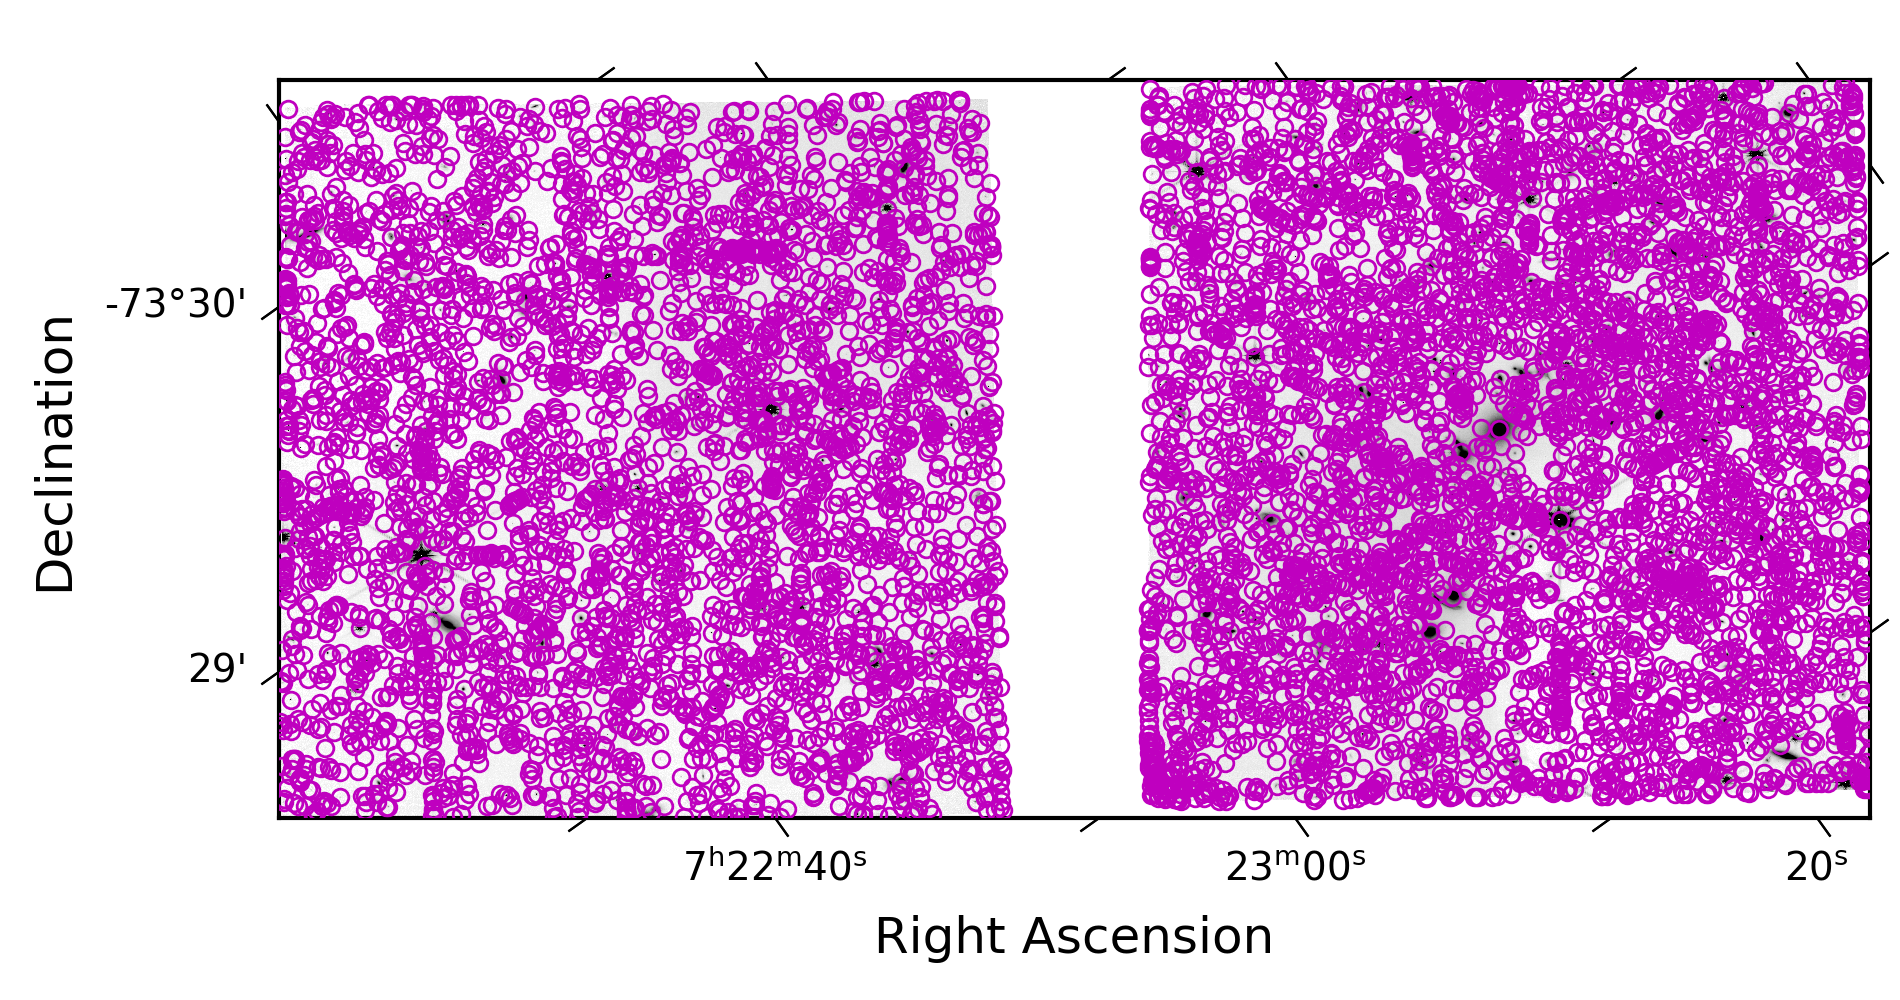

In [96]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=reference_wcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0.15, vmax=1)
plt.imshow(reference_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
#plt.plot(input_catalog['RA'], input_catalog['DEC'], 'co', mfc='None', transform=ax.get_transform('world'))
plt.plot(reference_catalog['RA'], reference_catalog['DEC'], 'mo', mfc='None', transform=ax.get_transform('world'))
#plt.plot(reference_catalog['RA'][ridx], reference_catalog['DEC'][ridx], 'r+', mfc='None', transform=ax.get_transform('world'))

In [24]:
# Input image to be tweaked to reference image
#input_image_dir = '/Users/dcoe/jw02736/L3/t'
input_image_dir = '../images'
input_image = 'jw02736-o001_t001_nircam_clear-f277w_i2d.fits'
input_image = os.path.join(input_image_dir, input_image)
input_hdu_list = fits.open(input_image)
input_idata = 1
input_wcs = HSTWCS(input_hdu_list, input_idata)
input_data = input_hdu_list[input_idata].data

Set DATE-AVG to '2022-06-07T01:43:31.255' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.946' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [45]:
input_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.7565272346779  -73.46766286056818  
CRPIX : 2521.171457988863  1148.410564664681  
PC1_1 PC1_2  : 0.8181887819309211  0.5749496648597994  
PC2_1 PC2_2  : 0.5749496648597994  -0.8181887819309211  
CDELT : 1.7474322795237e-05  1.7474322795237e-05  
NAXIS : 5062  2302

In [83]:
# Input catalog
input_catalog_dir = '../images'
input_catalog_file = 'jw02736-o001_t001_nircam_clear-f277w_cat.ecsv'
input_catalog_file = os.path.join(input_catalog_dir, input_catalog_file)
input_catalog = ascii.read(input_catalog_file)

In [84]:
# Replace sky_centroid with RA, DEC in degrees without units for tweakwcs
input_catalog['RA']  = input_catalog['sky_centroid'].ra.degree  # * u.degree
input_catalog['DEC'] = input_catalog['sky_centroid'].dec.degree # * u.degree
input_catalog.rename_column('xcentroid', 'x')
input_catalog.rename_column('ycentroid', 'y')
columns = list(input_catalog.columns)
columns = columns[:3] + ['RA', 'DEC'] + columns[4:-2]
input_catalog = input_catalog[columns]
input_catalog[:2]

<QTable length=2>
label     x     ...              sky_bbox_ur             
                ...                deg,deg               
int64  float64  ...                SkyCoord              
----- --------- ... -------------------------------------
    1 1695.4629 ... 110.67499951780398,-73.45959031077643
    2 1744.3411 ...   110.67751286326546,-73.459088928554

<IPython.core.display.Javascript object>


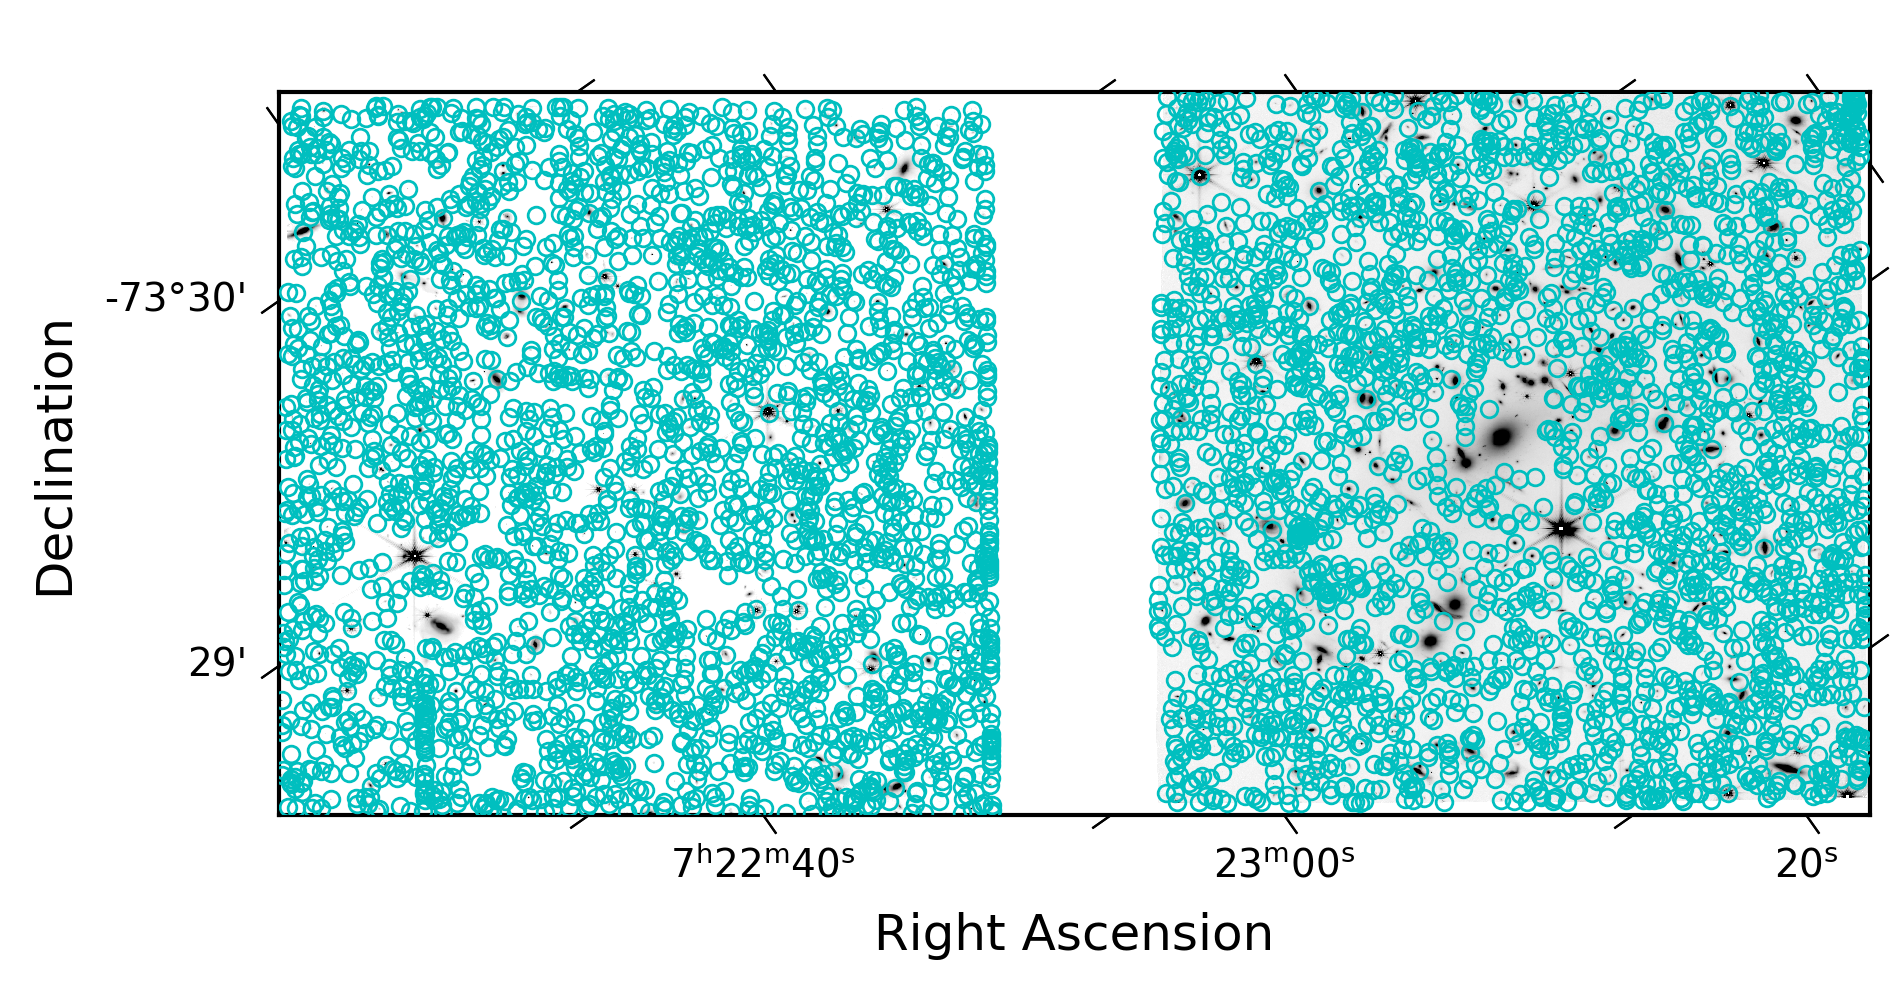

In [85]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=input_wcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0.1, vmax=1)
plt.imshow(input_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(input_catalog['RA'], input_catalog['DEC'], 'co', mfc='None', transform=ax.get_transform('world'))

In [86]:
# Match sources in the catalogs:
# https://tweakwcs.readthedocs.io/en/stable/matchutils.html
# All units in pixels, I think
# searchrad = search radius
# separation = required between catalog objects, otherwise both are thrown out
# tolerance = for match after initial solution
match = TPMatch(searchrad=2, separation=1, tolerance=5, use2dhist=False)
#match = TPMatch(searchrad=6, separation=3, tolerance=2, use2dhist=True)
input_wcs_corrector = FITSWCS(input_wcs)
ridx, iidx = match(reference_catalog, input_catalog, input_wcs_corrector)
len(ridx), len(iidx)

(4305, 4305)

In [90]:
# Set some initial offset; requires use2dhist = False
# https://tweakwcs.readthedocs.io/en/stable/matchutils.html
match = TPMatch(searchrad=2, separation=1, tolerance=1, use2dhist=False, xoffset=1, yoffset=1)
input_wcs_corrector = FITSWCS(input_wcs)
ridx, iidx = match(reference_catalog, input_catalog, input_wcs_corrector)
len(ridx), len(iidx)

(3237, 3237)

<IPython.core.display.Javascript object>


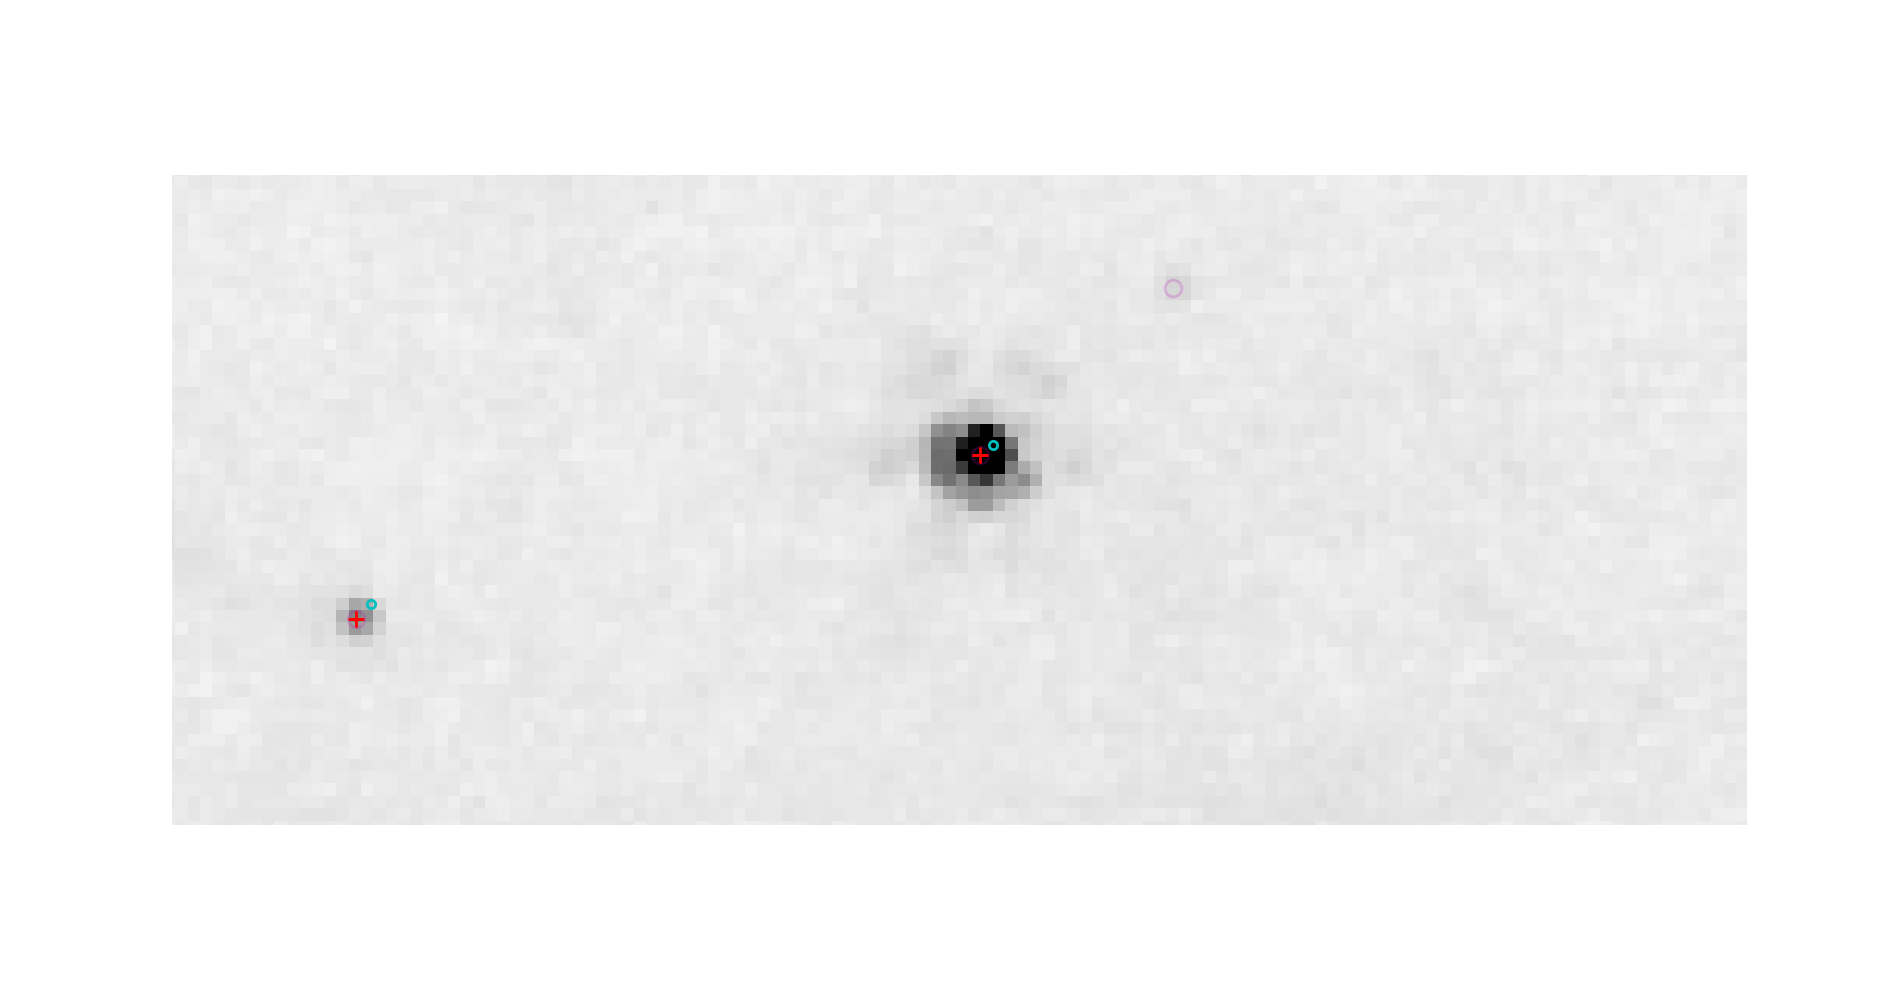

(-0.5, 10275.5, -0.5, 4765.5)

In [91]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=reference_wcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0.15, vmax=1)
plt.imshow(reference_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(input_catalog['RA'], input_catalog['DEC'], 'c.', mfc='None', transform=ax.get_transform('world'))
plt.plot(reference_catalog['RA'], reference_catalog['DEC'], 'mo', alpha=0.2, mfc='None', transform=ax.get_transform('world'))
plt.plot(reference_catalog['RA'][ridx], reference_catalog['DEC'][ridx], 'r+', mfc='None', transform=ax.get_transform('world'))
ax.axis('off')

In [92]:
# Align image WCS:
#aligned_imwcs = fit_wcs(input_catalog[ridx], reference_catalog[iidx], wcs_corrector).wcs
aligned_imwcs = fit_wcs(reference_catalog[ridx], input_catalog[iidx], input_wcs_corrector).wcs
aligned_imwcs
#input_catalog.meta['aligned_wcs'] = aligned_imwcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.75648063629104  -73.46766212711417  
CRPIX : 2521.171457988863  1148.410564664681  
PC1_1 PC1_2  : 0.8181997456238306  0.5749806785123192  
PC2_1 PC2_2  : 0.5749648144390724  -0.8181847505485862  
CDELT : 1.7474322795237e-05  1.7474322795237e-05  
NAXIS : 5062  2302

In [93]:
input_wcs  # for comparison

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 110.7565272346779  -73.46766286056818  
CRPIX : 2521.171457988863  1148.410564664681  
PC1_1 PC1_2  : 0.8181887819309211  0.5749496648597994  
PC2_1 PC2_2  : 0.5749496648597994  -0.8181887819309211  
CDELT : 1.7474322795237e-05  1.7474322795237e-05  
NAXIS : 5062  2302

In [94]:
# https://drizzlepac.readthedocs.io/en/latest/updatehdr.html
updatehdr.update_wcs(input_hdu_list, input_idata, aligned_imwcs, wcsname='TWEAK', reusename=True, verbose=True)

Updating header for ../images/jw02736-o001_t001_nircam_clear-f277w_i2d.fits[1]
WCS Keywords

CD_11  CD_12: 1.4297294882902692e-05 1.0046856034773465e-05
CD_21  CD_22: 1.0046856034773465e-05 -1.4297294882902692e-05
CRVAL    : 110.75648063629104 -73.46766212711417
CRPIX    : 2521.171457988863 1148.410564664681
NAXIS    : 5062 2302
Plate Scale : 0.06290756206285321
ORIENTAT : 144.9038927288069
WCSNAME  :  TWEAK


In [95]:
input_image_aligned_to_reference = 'f277w_corrected_WCS.fits'
input_hdu_list.writeto(input_image_aligned_to_reference, overwrite=True)

# With WCS fixed, can now align the input image to the reference image

In [97]:
from reproject import reproject_interp  # https://reproject.readthedocs.io/en/stable/

In [98]:
print("Reprojecting...")  # 1 minute
#reprojected_data, footprint = reproject_interp(input_hdu_list[input_idata], reference_header)
reprojected_data, footprint = reproject_interp(input_data, reference_header)

Reprojecting...


Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:17.412' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.538' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [101]:
fits.writeto('f277w_aligned_to_f200w.fits', reprojected_data, reference_header)